# Data Segmentation

## Segmented Data Folder Set-Up

In [1]:
import os
import pandas as pd

In [2]:
master_folder = "EMG_data_for_gestures-master"

In [3]:
output_folder = "segmented_data"
os.makedirs(output_folder, exist_ok=True)

In [4]:
for class_label in range(1, 7):
    os.makedirs(os.path.join(output_folder, str(class_label)), exist_ok=True)

In [5]:
for subject_folder in sorted(os.listdir(master_folder)):
    subject_path = os.path.join(master_folder, subject_folder)

    if os.path.isdir(subject_path):
        subject_number = int(subject_folder)
        
        for file_name in os.listdir(subject_path):
            if file_name.endswith('.txt'):
                file_path = os.path.join(subject_path, file_name)
                trial_number = 1 if file_name.startswith("1") else 2
                
                df = pd.read_csv(file_path, delim_whitespace=True)

                df = df[df["class"].notna()]
                df["class"] = df["class"].astype(int)
                df = df[df["class"].isin([1, 2, 3, 4, 5, 6])]

                # Detect breaks in continuity and group by segments
                df["Segment_ID"] = (df["class"].diff().abs() > 0).cumsum()
                grouped_segments = df.groupby("Segment_ID")

                # Save each segment in the corresponding gesture class folder
                segment_count = 0
                for _, segment in grouped_segments:
                    if len(segment) > 1:  # Ensure non-trivial segment length
                        class_label = segment["class"].iloc[0]
                        segment_count += 1
                        file_name = f"subject_{subject_number}_trial_{trial_number}_segment_{segment_count}.csv"
                        output_path = os.path.join(output_folder, str(class_label), file_name)
                        segment.drop(columns="Segment_ID", inplace=True)  # Drop Segment_ID before saving
                        segment.to_csv(output_path, index=False)
                        
                # print(f"Processed {segment_count} segments for subject {subject_number}, trial {trial_number}.")

## Clean Up `segmented_data` Folder

In [45]:
import shutil

if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
    print(f"'{output_folder}' folder has been cleaned up.")
else:
    print(f"'{output_folder}' folder does not exist.")

'segmented_data' folder has been cleaned up.


# Data Preprocessing
[EMGHandNet: A hybrid CNN and Bi-LSTM architecture for hand activity classification using surface EMG signals](https://www.sciencedirect.com/science/article/pii/S0208521622000080?casa_token=V4WvXP4kLFUAAAAA:85waKJ-zVbL2eahpxFeSgXnk46h0OP-LBJ-XU42jsqUaB3Dccsj10LeTnn_pyqMQZ_Uhjg62wg#t0020).
The paper above uses the UCI Gestures dataset and performed wavelet denoising as signal preprocessing which is why I have decided to use it as well. The following is that code:

In [10]:
pip install pywavelets

   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 4.2/4.2 MB 31.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pywt

In [7]:
# Path to the segmented data folder
segmented_data_folder = "segmented_data"

# Define wavelet parameters
wavelet = 'sym8'  # Symlet wavelet of order 8
level = 4  # Decomposition level

In [8]:
def wavelet_denoise(emg_signal, wavelet='sym8', level=4):
    """
    Perform wavelet denoising on an EMG signal using Symlet wavelet.
    
    Parameters:
    - emg_signal: np.array, input EMG signal to be denoised
    - wavelet: str, wavelet type
    - level: int, level of decomposition
    
    Returns:
    - denoised_emg_signal: np.array, denoised EMG signal
    """
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(emg_signal, wavelet, level=level)
    
    # Estimate noise level (sigma) using the Median Absolute Deviation
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    
    # Calculate universal threshold
    uthresh = sigma * np.sqrt(2 * np.log(len(emg_signal)))
    
    # Apply soft thresholding
    denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, value=uthresh, mode='soft') for c in coeffs[1:]]
    
    # Reconstruct the denoised signal
    denoised_emg_signal = pywt.waverec(denoised_coeffs, wavelet)
    
    # Ensure the reconstructed signal length matches the original
    return denoised_emg_signal[:len(emg_signal)]

In [9]:
# Iterate through each class subfolder (1 to 6)
for class_folder in sorted(os.listdir(segmented_data_folder)):
    class_path = os.path.join(segmented_data_folder, class_folder)
    
    if os.path.isdir(class_path):  # Ensure it's a folder
        for file_name in sorted(os.listdir(class_path)):
            if file_name.endswith('.csv'):
                file_path = os.path.join(class_path, file_name)
                
                # Load the EMG data from the CSV file
                df = pd.read_csv(file_path)
                
                # Apply wavelet denoising to each channel
                for channel in [col for col in df.columns if col.startswith('Channel')]:
                    df[channel] = wavelet_denoise(df[channel].values, wavelet=wavelet, level=level)
                
                # Save the denoised version, replacing the original file
                df.to_csv(file_path, index=False)
                
                # print(f"Denoised and saved: {file_path}")

# Data Visualization

In [10]:
import matplotlib.pyplot as plt

In [11]:
# Path to the segmented data folder
segmented_data_folder = "segmented_data"

# List of class labels (subfolders named 1 to 6)
class_labels = [str(i) for i in range(1, 7)]

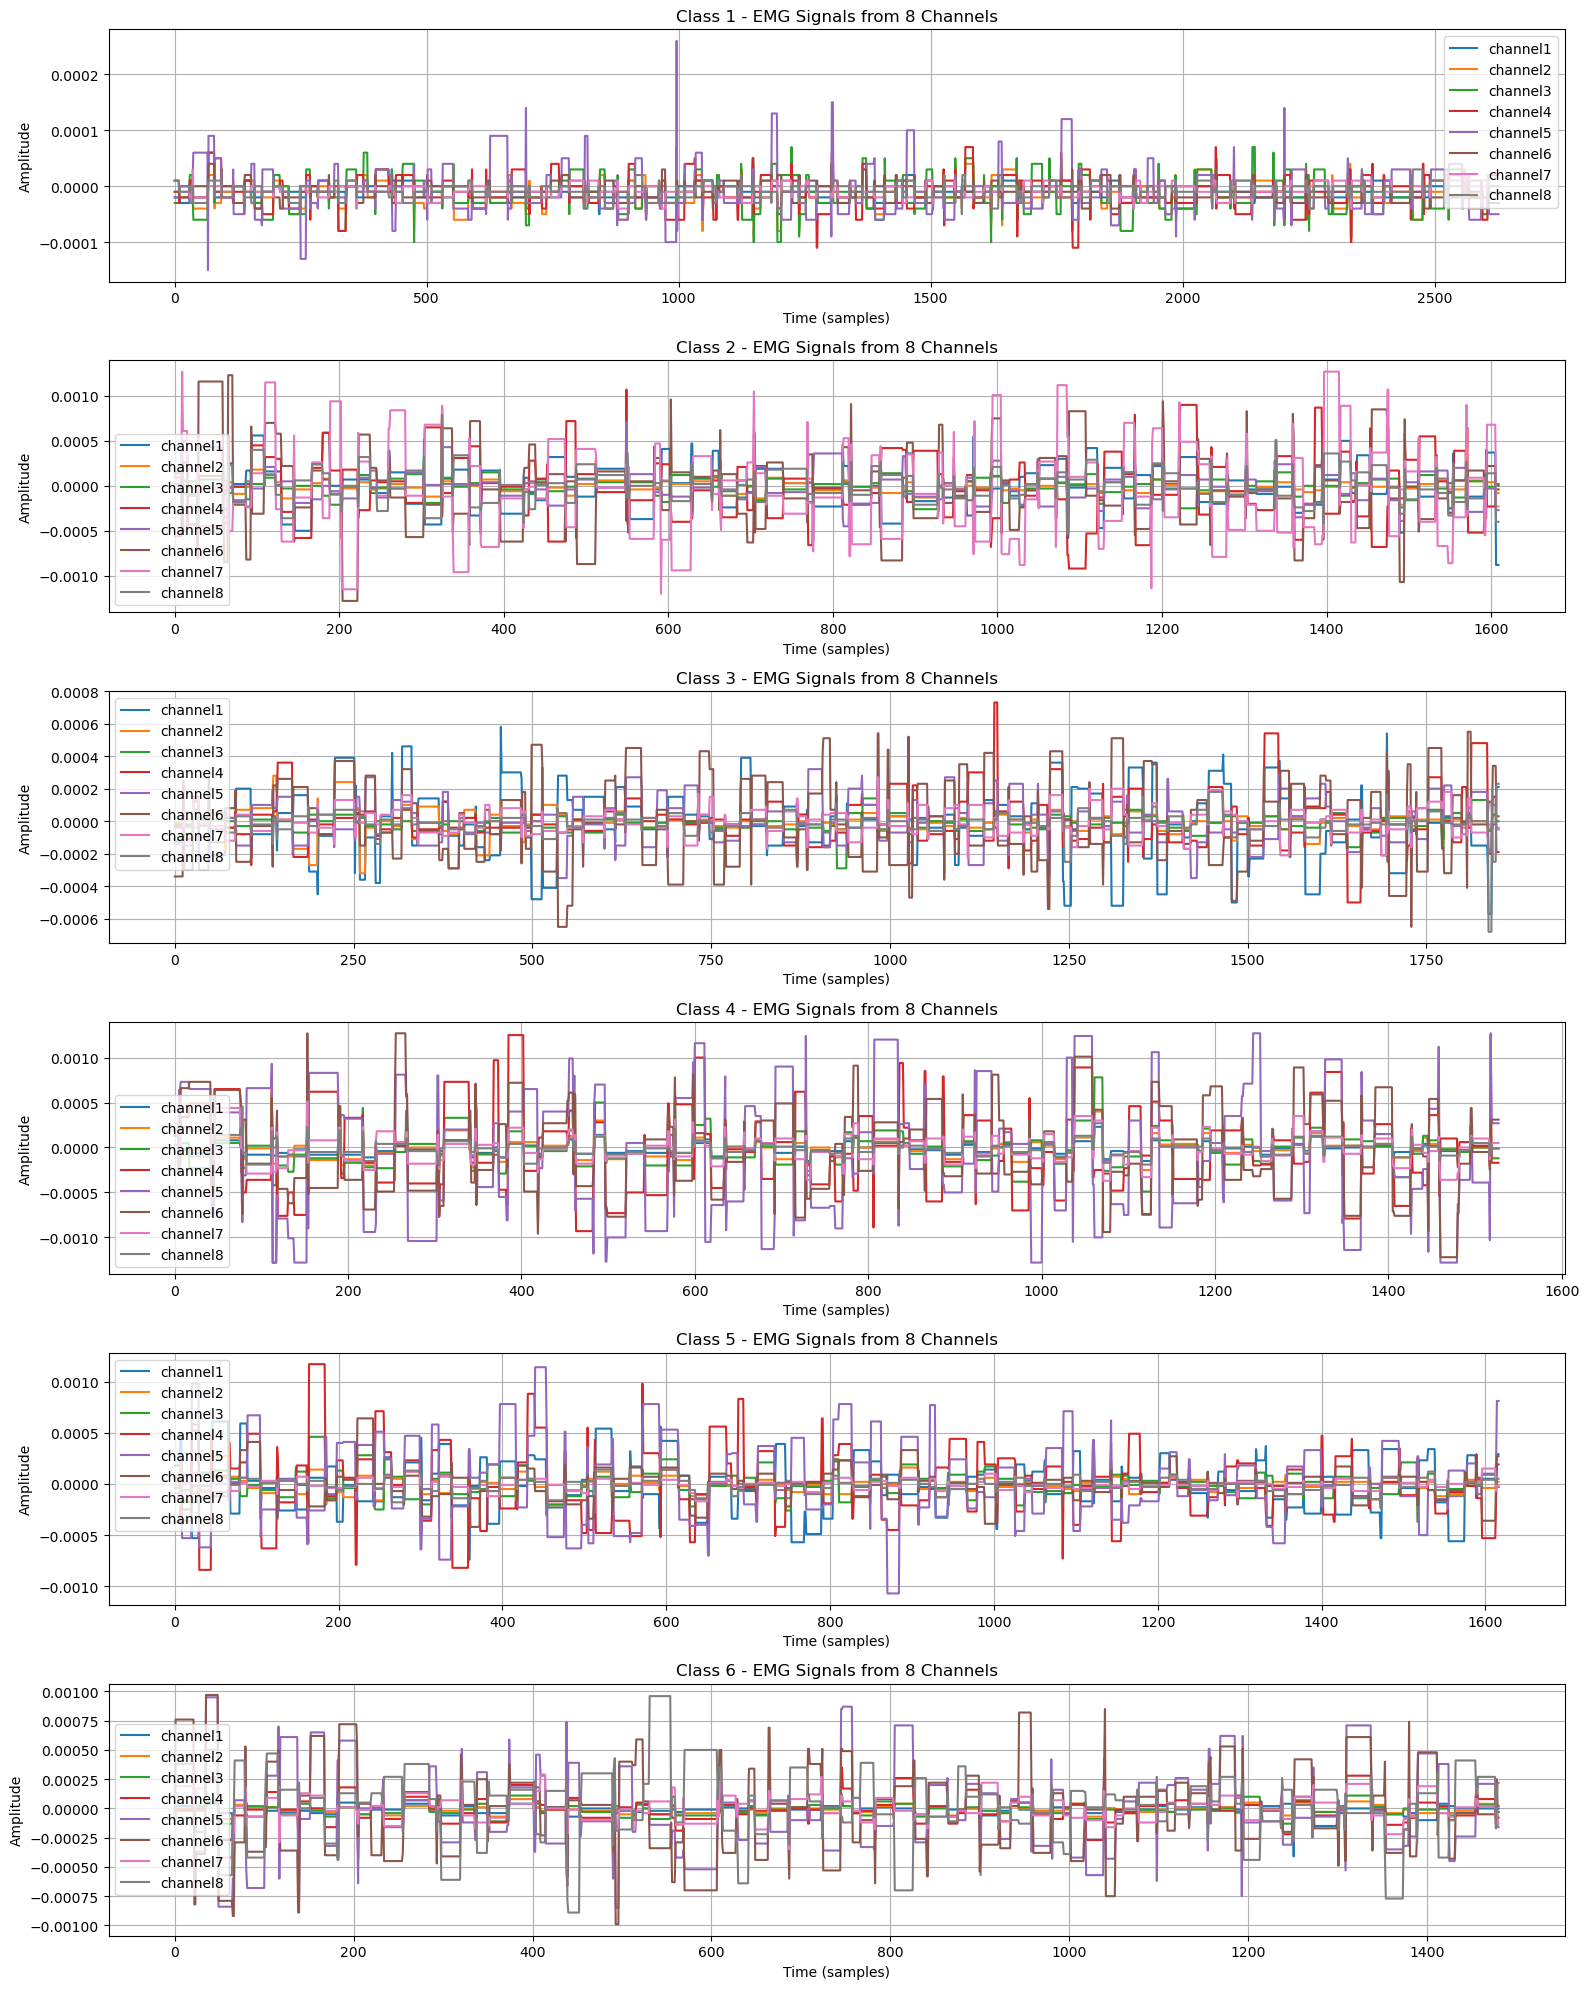

In [16]:
# Create a figure to plot signals from one file per class
plt.figure(figsize=(16, 20))
plot_index = 1

for class_label in class_labels:
    class_path = os.path.join(segmented_data_folder, class_label)
    
    # Select one CSV file from the current class folder
    file_name = sorted(os.listdir(class_path))[0]
    file_path = os.path.join(class_path, file_name)
    
    # Load the data
    df = pd.read_csv(file_path)
    
    # Plot each channel signal
    plt.subplot(len(class_labels), 1, plot_index)
    for channel in [col for col in df.columns if col.startswith('channel')]:
        plt.plot(df.index, df[channel], label=channel)
    
    plt.title(f"Class {class_label} - EMG Signals from 8 Channels")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    
    plot_index += 1

plt.tight_layout()
plt.show()

# Data Normalization

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [28]:
# Path to the segmented data folder
segmented_data_folder = "segmented_data"

# List of class labels (subfolders named 1 to 6)
class_labels = [str(i) for i in range(1, 7)]

# 1000 Hz x 3 secs per gesture = 3000 samples per gesture trial
N_T = 3000

# Initialize lists to store input-output pairs
X_processed = []  # Inputs (normalized EMG sequences)
y = []  # Outputs (gesture class labels)

In [29]:
# Iterate through each class folder
for class_label in class_labels:
    class_path = os.path.join(segmented_data_folder, class_label)
    
    for file_name in sorted(os.listdir(class_path)):
        if file_name.endswith('.csv'):
            file_path = os.path.join(class_path, file_name)
            
            # Load the EMG data segment
            df = pd.read_csv(file_path)
            segment = df.iloc[:, 1:9].values
            
            # Apply Min-Max normalization per channel
            normalized_segment = np.zeros_like(segment)
            for channel_idx in range(segment.shape[1]):
                channel = segment[:, channel_idx]
                channel_min = np.min(channel)
                channel_max = np.max(channel)
                if channel_max > channel_min:  # Avoid division by zero
                    normalized_segment[:, channel_idx] = (channel - channel_min) / (channel_max - channel_min)
                else:
                    normalized_segment[:, channel_idx] = channel  # No normalization if constant signal
            
            # Truncate or pad the segment to length N_T (3000 samples)
            if normalized_segment.shape[0] > N_T:
                # Truncate if segment length exceeds N_T
                processed_segment = normalized_segment[:N_T, :]
            else:
                # Pad if segment length is less than N_T
                processed_segment = pad_sequences(
                    [normalized_segment], maxlen=N_T, dtype='float32', padding='post', truncating='post'
                )[0]
            
            # Append the processed segment and corresponding class label
            X_processed.append(processed_segment)
            y.append(int(class_label))

In [30]:
# Convert the processed list to numpy arrays
X = np.array(X_processed)
y = np.array(y)

print(f"Prepared {len(X)} input-output pairs.")
print(f"Input shape: {X.shape} (segments, time steps, channels)")
print(f"Output shape: {y.shape} (segments,)")

Prepared 864 input-output pairs.
Input shape: (864, 3000, 8) (segments, time steps, channels)
Output shape: (864,) (segments,)


# Training and Validation Sets Split

In [35]:
from sklearn.model_selection import train_test_split

# Flatten X and y so that each segment is treated independently
X_flattened = X.reshape(-1, 3000, 8)
y_flattened = y.reshape(-1)

# Perform 70%-30% split using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y_flattened, test_size=0.3, stratify=y_flattened, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: (604, 3000, 8), (604,)
Testing set: (260, 3000, 8), (260,)


## Trial-Wise Standardization
Consistent with the paper. May have to attempt Channel-Wise Standardization
| Aspect            | Channel-Wise Standardization                                  | Trial-Wise Standardization                                      |
|-------------------|---------------------------------------------------------------|-----------------------------------------------------------------|
| Scope of Mean/STD | Mean and standard deviation are computed across all segments. | Mean and standard deviation are computed within each trial.     |
| Consistency       | Ensures consistent scaling across the entire dataset.         | Ensures consistent scaling within each trial.                   |
| Effect on Data    | Retains global structure of the data.                         | Removes global differences between trials (centers each trial). |
| Used For          | Common in machine learning when global consistency is needed. | Used when trials vary significantly in magnitude or baseline.   |

In [36]:
# Apply trial-wise standardization
X_train_standardized = np.zeros_like(X_train)
X_test_standardized = np.zeros_like(X_test)

# Standardize each trial in the training set
for i in range(X_train.shape[0]):
    mean = X_train[i].mean(axis=0)  # Mean for each channel in the trial
    std = X_train[i].std(axis=0)    # Std for each channel in the trial
    X_train_standardized[i] = (X_train[i] - mean) / std

# Standardize each trial in the testing set
for i in range(X_test.shape[0]):
    mean = X_test[i].mean(axis=0)  # Mean for each channel in the trial
    std = X_test[i].std(axis=0)    # Std for each channel in the trial
    X_test_standardized[i] = (X_test[i] - mean) / std

# LSTM Model
We’ll design a simple LSTM model with:
1. An LSTM layer to capture temporal dependencies.
2. Dropout to reduce overfitting.
3. Fully connected (Dense) layers to map the learned features to the output classes.
4. Softmax activation in the output layer to produce a probability distribution over the 6 gesture classes.

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [41]:
# Adjust labels to be 0-based
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1

# One-hot encode the labels (6 gesture classes)
y_train_one_hot = to_categorical(y_train_adjusted, num_classes=6)
y_test_one_hot = to_categorical(y_test_adjusted, num_classes=6)

In [42]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(3000, 8), return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))  # Output layer with 6 classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                18688     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 6)                 198       
                                                                 
Total params: 20966 (81.90 KB)
Trainable params: 20966 (81.90 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [43]:
# Train the model
history = model.fit(X_train, y_train_one_hot, epochs=30, batch_size=16, validation_data=(X_test, y_test_one_hot))

Epoch 1/30
38/38 [==============================] - 19s 465ms/step - loss: 1.7927 - accuracy: 0.1457 - val_loss: 1.7918 - val_accuracy: 0.1654
Epoch 2/30
38/38 [==============================] - 18s 487ms/step - loss: 1.7917 - accuracy: 0.1540 - val_loss: 1.7919 - val_accuracy: 0.1654
Epoch 3/30
38/38 [==============================] - 19s 496ms/step - loss: 1.7914 - accuracy: 0.1556 - val_loss: 1.7921 - val_accuracy: 0.1654
Epoch 4/30
38/38 [==============================] - 19s 494ms/step - loss: 1.7931 - accuracy: 0.1705 - val_loss: 1.7919 - val_accuracy: 0.1654
Epoch 5/30
38/38 [==============================] - 19s 507ms/step - loss: 1.7907 - accuracy: 0.1424 - val_loss: 1.7919 - val_accuracy: 0.1654
Epoch 6/30
38/38 [==============================] - 19s 502ms/step - loss: 1.7893 - accuracy: 0.1391 - val_loss: 1.7918 - val_accuracy: 0.1654
Epoch 7/30
38/38 [==============================] - 19s 509ms/step - loss: 1.7887 - accuracy: 0.1490 - val_loss: 1.7918 - val_accuracy: 0.1692

In [44]:
# Evaluate the model on the testing set
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test Accuracy: {test_accuracy:.2f}")

9/9 [==============================] - 1s 150ms/step - loss: 1.7919 - accuracy: 0.1654
Test Accuracy: 0.17


# Continue with hyperparameter tuning?